# Data Girlies Kaggle Competition
#### Matthew Phi, Cathy Kim, Angelina Jaglinski

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
import catboost as cb

# A.1) Data Cleaning

Steps we took:
- Imputed missing values using the column mean
- Scaled data using StandardScaler
- Dropped columns that with all of the same value, as they do not add anything new for prediction
- Dropped columns that are not numeric

In [2]:
# Upload the train and test data sets
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Drop id column and seperate target values
X = data.drop(["id", "y"], axis = 1)
y = data["y"]

X_test = test.drop(["id"], axis = 1)

In [4]:
# Use log(y) based on distribution found in EDA
y = np.log(y)

In [5]:
# Use the column mean to fill NA values
X = X.fillna(X.mean())
X_test = X_test.fillna(X_test.mean())

C:\Users\jagli\AppData\Local\Temp\ipykernel_19964\3466419838.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X = X.fillna(X.mean())
C:\Users\jagli\AppData\Local\Temp\ipykernel_19964\3466419838.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_test = X_test.fillna(X_test.mean())


In [6]:
# Scale the data
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X_test = sc.transform(X_test)

# Put scaled data into dataframe
X = pd.DataFrame(X)
X_test = pd.DataFrame(X_test)

In [7]:
# Drop columns that contain all the same value
X = X.loc[:,X.apply(pd.Series.nunique) != 1]

In [8]:
# Drop columns that are not numeric
non_numeric_cols = X.columns[X.isna().any()].tolist()
X = X.drop(non_numeric_cols, axis=1)
X_test = X_test.drop(non_numeric_cols, axis=1)

# A.2) Exploratory Data Analysis (EDA)

- There were 473 features that contained missing values. We fixed this by imputing it with the mean.
- There were 11 columns that were of object type, which we removed in the data cleaning step.
- We visualized the distribution of the target variable 'y', and saw that it is heavily skewed to the right. This let us know that we should use log(y) in our model.
- We visualized the important features in the dataset using PCA and found that 129 components explain 95% of the variance.

In [9]:
# Many columns have null values - fixed by filling with mean
data.isnull().sum()

id        0
x001     10
x002      0
x003      3
x004      0
       ... 
x762     53
x763      0
x764      3
x765    375
y         0
Length: 767, dtype: int64

In [10]:
# Some columns are object types - removed these columns
data.dtypes.value_counts()

float64    657
int64       99
object      11
dtype: int64

<AxesSubplot:ylabel='Frequency'>

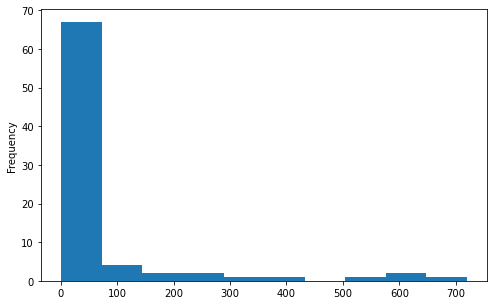

In [11]:
# y values skewed right - used log(y) in our model
y.value_counts().plot(kind="hist",
                      figsize=(8,5))

129  components explain 95% of variance


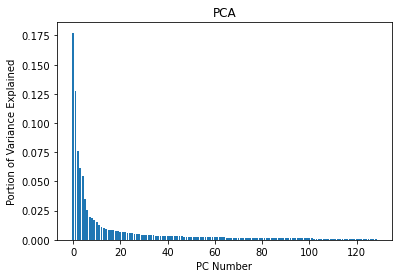

In [12]:
# Lots of important features in dataset
pca = PCA(n_components=0.95, svd_solver="full")
n = pca.fit(X).n_components_
print(n, " components explain 95% of variance")

variances = pca.explained_variance_ratio_
plt.bar(range(129), variances)
plt.xlabel('PC Number')
plt.ylabel('Portion of Variance Explained')
plt.title("PCA")
plt.show()

# A.3) Feature Selection/reduction
## XGBoost

We developed a XGBoost model with default parameters to conduct feature selection. We then dropped all of the predictors that had feature importances of 0. We developed our final model based on the reamining features.

We had also tried using a Lasso model for feature selection, which gave us a relatively good final model with an RMSE value of 8.7769, but it didn't quite meet the top benchmark.

In [13]:
# Fit XGBoost model
xg_model = XGBRegressor()
xg_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [14]:
# Use XGBoost model to get all important features
importances = xg_model.feature_importances_
important_features = (np.where(importances!=0)[0]).tolist()
X = X.iloc[:, important_features]

# A.4) Developing the Model
## CatBoost

We used a CatBoostRegressor model with RMSE as the loss function. We found this to be the model that far outperformed the other models we had tried (Random Forest, Neural Network, Lasso, etc).

In [15]:
# Train CatBoost model on dataset with only important features
model_cat = cb.CatBoostRegressor(loss_function="RMSE", verbose=False)
model_cat.fit(X, y)

In [16]:
# Get predictions from test data
test_pred = np.exp(model_cat.predict(X_test))

# Get intercept
train_pred = np.exp(model_cat.predict(X))
b = np.mean(np.exp(y) - train_pred)
preds = test_pred + b

In [17]:
# Convert predictions to csv file in correct format
d = {'id': range(5380, 9783), 'y': preds}
df = pd.DataFrame(data=d)
df.to_csv("final_predictions.csv", index=False)

# A.5) Discussion

Our team initially tried using PCA, as this was a rather large dataset. However, we found that all of the models we tried utilizing PCA gave us relatively high RMSE values (around 9 or 10). 

We also wanted to implement a MARS model, with the knowledge that a MARS model would be useful for capturing nonlinearities and interactions; however, even after troubleshooting, we were not able to get MARS (pyearth) to install properly on our devices.

Because this dataset contained a large number of features, we knew that dimensionality reduction would be crucial to get us below the 8.75 threshold. After trying random forest, lasso, and XGBoost, we found that XGBoost was the most successful in reducing our RMSE in the final model.

- Throughout the feature selection process, the runtime was often a big challenge, as things like RFE and Grid Search took a very long time to run.

CatBoost was the model that performed the best by far. The runtime was reasonable, and gave us the lowest RMSE value. We used an RMSE loss function and otherwise default inputs to get our final predictions.

# A.6) Conclusion

#### Q: Do you feel that you gain valuable experience, skills, and/or knowledge? If yes, please explain what they were. If no, please explain.

Yes, This dataset was one with a lot of features and the dataset was anonymized, which provided us with a challenge. Through trial and error, our team learned what we had to prioritize in our EDA and data preparation steps in order to set ourselves up in the best way for the final model step. 

We tried out different dimensionality reduction methods such as PCA, Lasso, Random Forest, and ultimately XGBoost. We learned the pros and cons of various feature selection methods through trial and error.

Our team also had to learn how to balance the runtime with the complexity of the model. At the beginning, we found that some of the models we wanted to run would run for several hours, which was not the most feasible.

While working as a group, we learned how to effectively communicate with each other regarding our data cleaning steps, EDA, the various models we have tried, and what worked and what didn't. We also utilized GitHub to look at each other's code and add onto what they have already done.

Through our EDA presentation, we learned how to condense all the work we have done into a short presentation by prioritizing the most important information.

#### Q: What are things you liked/disliked about the project and/or work on the project?

We enjoyed working as a group because we were able to split up the models we would each try, and communicate with one another on how it performed.

We liked that the objective of this project was very clear and there were thresholds that were provided to us.

This was a comprehensive prediction problem that tested our ability on the entire statistical modeling pipeline (data cleaning, EDA, feature selection, modeling).